In [64]:
# Usual imports 
import os
import random
import numpy as np
import torch
import matplotlib.pyplot as plt

import urllib.request

# External imports
from segment_anything import sam_model_registry, SamPredictor

In [ ]:
data_dir = "...\data"
DATASET_DIR = data_dir + r"\test_image"

SAM_URL = "https://dl.fbaipublicfiles.com/segment_anything/sam_vit_b_01ec64.pth"
SAM_CHECKPOINT = r".\sam_vit_b_01ec64.pth"
MODEL_TYPE = "vit_b"

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Device utilisé : {DEVICE}")

# download model if needed
if not os.path.exists(SAM_CHECKPOINT):
    print(f"Le modèle '{SAM_CHECKPOINT}' n'existe pas.")
    print(f"Téléchargement en cours depuis {SAM_URL} ... (environ 375 Mo)")
    try:
        urllib.request.urlretrieve(SAM_URL, SAM_CHECKPOINT)
    except Exception as e:
        if os.path.exists(SAM_CHECKPOINT):
            os.remove(SAM_CHECKPOINT)
        raise e
else:
    print(f"found model : {SAM_CHECKPOINT}")



Device utilisé : cuda
found model : .\sam_vit_b_01ec64.pth


In [66]:
# load model
sam = sam_model_registry[MODEL_TYPE](checkpoint=SAM_CHECKPOINT)
sam.to(device=DEVICE)
predictor = SamPredictor(sam)

In [67]:
# get basic segmentation function using traditional image processing 

import cv2
def get_basic_seg(image_path):
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # conversion to have white object on black background
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

    # otsu thresholding
    _, thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

    # remove small noise
    kernel = np.ones((3,3), np.uint8)
    thresh = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel, iterations=1)

    # find biggest contour
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    if not contours:
        return image, None # no contours found

    # choose biggest contour
    c = max(contours, key=cv2.contourArea)

    # convert to bounding box
    x, y, w, h = cv2.boundingRect(c)

    # add padding for security 
    h_img, w_img = image.shape[:2]
    pad = 5
    x = max(0, x - pad)
    y = max(0, y - pad)
    w = min(w_img - x, w + 2*pad)
    h = min(h_img - y, h + 2*pad)

    bbox = np.array([x, y, x + w, y + h]) 

    return image, bbox, thresh

In [68]:
from pathlib import Path

def process_random_image():
    # chosse a random class and a random image
    all_classes = [d for d in Path(DATASET_DIR).iterdir() if d.is_dir()]

    random_class = random.choice(all_classes)

    
    images_in_class = list(list(random_class.glob("*.jpg")))

    random_image_path = random.choice(images_in_class)

    # apply basic otsu segmentation
    image_rgb, bbox, otsu_mask = get_basic_seg(random_image_path)

    predictor.set_image(image_rgb)

    masks, scores, logits = predictor.predict(
        point_coords=None,
        point_labels=None,
        box=bbox[None, :],
        multimask_output=True
    )

    best_idx = np.argmax(scores) # choose best seg
    final_mask = masks[best_idx]

    # viz
    fig, ax = plt.subplots(1, 4, figsize=(15, 5))
    
    ax[0].imshow(image_rgb)
    x0, y0, x1, y1 = bbox
    rect = plt.Rectangle((x0, y0), x1-x0, y1-y0, fill=False, edgecolor='red', linewidth=2)
    ax[0].add_patch(rect)

    ax[1].imshow(otsu_mask, cmap='gray')
    rect2 = plt.Rectangle((x0, y0), x1-x0, y1-y0, fill=False, edgecolor='red', linewidth=1, linestyle='--')
    ax[1].add_patch(rect2)
    
    ax[2].imshow(final_mask, cmap='gray')

    ax[3].imshow(image_rgb)
    overlay = np.zeros((*final_mask.shape, 4))
    overlay[final_mask] = [0, 1, 0, 0.4] 
    ax[3].imshow(overlay)
    
    for a in ax: a.axis('off')
    plt.tight_layout()
    plt.show()

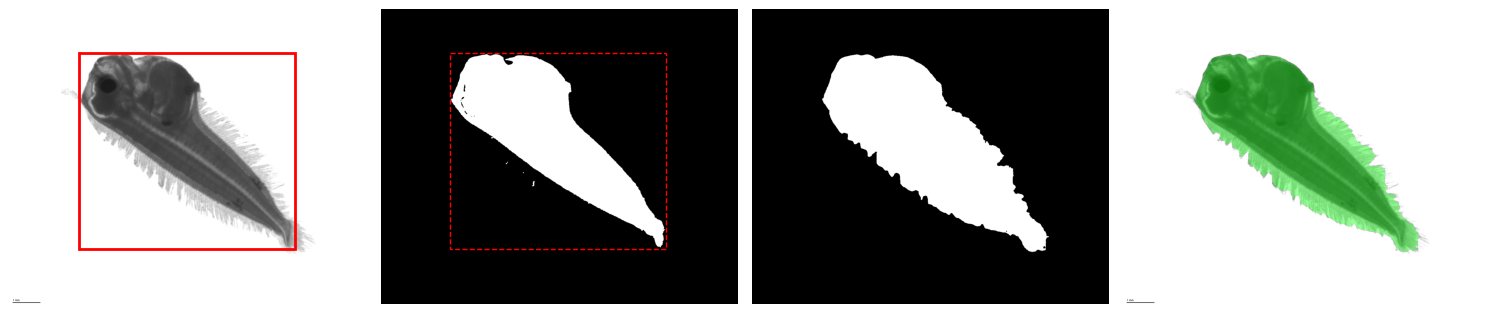

In [69]:
process_random_image()